In [1]:
# necessary imports

import skimage.io
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
import time


<B>Q1. Use the covariance matching technique to find the correct match in the color image
given on the WWW site (target.jpg). The model covariance matrix (of <x,y,R,G,B>
features) is given below (notice x,y vs. row,col!).
modelCovMatrix = [47.917 0 -146.636 -141.572 -123.269;
0 408.250 68.487 69.828 53.479;
-146.636 68.487 2654.285 2621.672 2440.381;
-141.572 69.828 2621.672 2597.818 2435.368;
-123.269 53.479 2440.381 2435.368 2404.923];
Test all possible overlapping windows (each of size 70 rows by 24 columns, with the
upperleft-corner as the window origin) in the image with the given model. Save the
match distance for each box location in the image at each pixel location (for the
origin of the window). Plot/display the match-distance-image. Provide the location of
the best match distance for the best candidate. Note that the above given covariance
matrix is biased (normalized with 1/(M*N)), and Matlab’s cov function is unbiased
by default using 1/(M*N-1), so call cov( X, 1 ) to make it consistent (biased).
Leave the image with colors ranging 0-255 (do not scale/normalize the colors).
NOTE: make sure not to take a log() of zero at any time! [5 pts] </B>

(240, 320, 3)

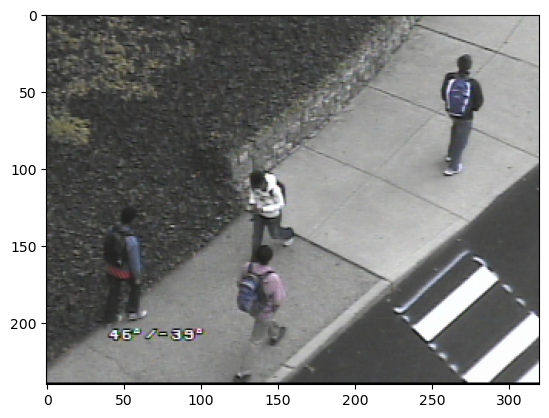

In [2]:
# read image
image = skimage.io.imread(fname="target.jpg")

plt.imshow(image)

image.shape

In [3]:
# given CModel 

CModel = np.array([[47.917, 0, -146.636, -141.572, -123.269], 
                   [0, 408.250, 68.487, 69.828, 53.479],
                   [-146.636, 68.487, 2654.285, 2621.672, 2440.381],
                   [-141.572, 69.828, 2621.672, 2597.818, 2435.368],
                   [-123.269, 53.479, 2440.381, 2435.368, 2404.923]])

CModel

array([[  47.917,    0.   , -146.636, -141.572, -123.269],
       [   0.   ,  408.25 ,   68.487,   69.828,   53.479],
       [-146.636,   68.487, 2654.285, 2621.672, 2440.381],
       [-141.572,   69.828, 2621.672, 2597.818, 2435.368],
       [-123.269,   53.479, 2440.381, 2435.368, 2404.923]])

In [4]:
''' function to extract out images of the desired size using windowing operation'''

def windowing_operation(image, size):
    image_set = []
    index = []
    for i in range(0, image.shape[0] - 70 + 1 ):
        for j in range(0, image.shape[1] - 24 + 1):
            image_set.append(image[i:i + size[0], j:j + size[1]])
            index.append((i, j))
    return image_set, index

''' function to find covariance between two matrices'''

def find_covariance(window):
    feature_vector = np.zeros(shape=(5, window.shape[0] * window.shape[1]))
    
    for i in range(0, window.shape[0]):
        for j in range(0, window.shape[1]):
            feature_vector[:, i*window.shape[1] +j]= np.array([[i, j, window[i, j, 0], window[i, j, 1], window[i, j, 2]]])
    CCandidate = np.cov(feature_vector, bias=True)

    return CCandidate

''' function to find Riemannian distance between two covariance matrices'''

def dist_bw_cov_matrices(cm, cc):
    w, v = scipy.linalg.eig(cm, cc)
    p = ((np.log(w))**2).sum()
    return np.sqrt(p)

In [5]:
# find all the images sets for which candidate covariance will be calculated for comparison
image_set, index = windowing_operation(image, (70, 24))

len(image_set)

50787

In [6]:
# compare the distances of found covariance matrices with the given matrix

start_time = time.time()
min_distance = math.inf

for i in range(len(image_set)):
    distance = dist_bw_cov_matrices(CModel, find_covariance(image_set[i]))
    if distance < min_distance:
        min_distance = distance
        location = index[i]
print("Time it takes to find the best match is " + str(time.time() - start_time))

Time it takes to find the best match is 94.47810506820679


In [7]:
location

(1, 258)

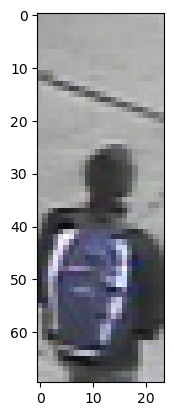

In [8]:
plt.imshow(image[location[0]:location[0] + 70, location[1]:location[1] + 24])

- Total windows created: 50787
- The best match found is the boy with the blue bag.
- Time it takes to run the code is approx 2.14 minutes. 

<B>Q2. Create a function to extract a feature vector of pixel information in a circular
neighborhood (< radius) around (x,y):
[ X ]=circularNeighbors(img, x, y, radius);
For each pixel, use the same format to return as used above (<xi,yi,R,G,B>). That is, X
should be a Kx5 matrix, where each row is for one of the pixels in the neighborhood.
Assume that the (x,y) passed into the function are real (non-integer) values, and do
NOT round them in the function for computation of the neighborhood. [2 pts] </B>

In [9]:
def circularNeighbors(img, x, y, radius):
    neighbour_vectors = np.zeros((2*radius*2*radius, 5))
    p = 0
    for i in range(-radius, radius):
        for j in range(-radius, radius):
            neighbour_vectors[p] = (np.array([(x+i), (y+j), img[x+i,y+j, 0], img[x+i,y+j, 1], img[x+i, y+j, 2]]))
            p += 1
    return neighbour_vectors

In [10]:
X = circularNeighbors(image, 5, 5, 5)

In [11]:
X.shape

(100, 5)

<B>Q3. Create a function to build a color histogram from the neighborhood info:
[ hist ]=colorHistogram(X, bins, x, y, h);
The histogram (hist) should be a bins x bins x bins color cube (RxGxB). The bins
should be evenly spaced. For example, if bins=4 then the pixel-value limits for each
bin will be {0-63, 64-127, 128-191, 192-255}. Be sure to test your code on pixels
with possible RGB values of 0 and 255. Weight the construction of the histogram
using an Epanechnikov kernel centered at real-valued (x, y) and with bandwidth h.
Normalize the histogram/cube so it sums to 1. (This function will be used to make
your model histogram “q_model” and to make the candidate test histogram “p_test”)
[3 pts] </B>

In [12]:
def colorHistogram(X, bins, x, y, h):
    
    hist = np.zeros((bins,bins,bins))
    
    for i in X:
        temp = 1-(np.sqrt((i[0]-x)**2 + (i[1]-y)**2)/h)**2
        if temp < 0:
            temp = 0
        hist[int(i[2]//bins), int(i[3]//bins), int(i[4]//bins)] += temp
    return (hist/np.sum(hist))

In [13]:
hist = colorHistogram(X, 15, 5, 5, 20)

<B>Q4. Create a function to calculate a vector of the mean-shift weights (w), where there is a
weight wi for each pixel i in the neighborhood: [2 pts] </B>

In [14]:
def meanShiftWeights(q_model , p_test, bins):
    w = np.zeros((bins,bins,bins))
    for i in range(bins):
        for j in range(bins):
            for k in range(bins):
                if p_test[i,j,k] == 0:
                    w[i,j,k] = 0
                else:
                    w[i,j,k] = np.sqrt(q_model[i,j,k]/p_test[i,j,k])
    return w

<B>Q5. Load the images img1.jpg and img2.jpg (from the website), and use the functions
above to perform mean-shift tracking.
Build a model from img1 using a circular neighborhood with a radius of 25 pixels
centered at (x0,y0) = (150.0, 175.0) and a color histogram of size 16x16x16 (cube).
Build the weighted cube histogram using an Epanechnikov kernel with bandwidth
h = 25 (same as the earlier radius).
Run 25 iterations of mean-shift tracking on img2. DO NOT ROUND coordinates or
values at any time!
Report the final (x, y) location (DO NOT ROUND) and Euclidean distance between
the last two iterations (see Step 4 on the Algorithm slide). [3 pts] </B>

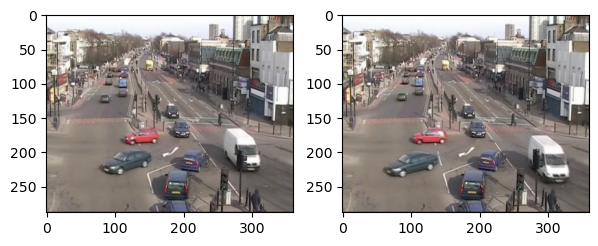

In [15]:
# plot image 1 and image 2

img1 = skimage.io.imread(fname="img1.jpg")
img2 = skimage.io.imread(fname="img2.jpg")

fig = plt.figure(figsize=(7, 7))

rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(img1)

fig.add_subplot(rows, columns, 2)
plt.imshow(img2)

In [16]:
# current location
circular_neighbourhood_1 = circularNeighbors(img1, 150, 175, 25)
q = colorHistogram(circular_neighbourhood_1, 16, 150, 175, 25)

# target location
circular_neighbourhood_2 = circularNeighbors(img2, 150, 175, 25)
p = colorHistogram(circular_neighbourhood_2, 16, 150, 175, 25)

# calculate weights
w = meanShiftWeights(q , p, 16)

In [17]:
x, y = 150, 175
x2 = []
y2 = []

for i in range(25):
 
    circular_neighbourhood = circularNeighbors(img2, int(x), int(y), 25)
    p = colorHistogram(circular_neighbourhood, 16, int(x), int(y), 25)
    w = meanShiftWeights(q, p, 16)
    
    x1 = np.zeros((w.shape))
    y1 = np.zeros((w.shape))
    
    for i in range(-25, 25):
        x1 = x1 + (x+i) * w
        y1 = y1 + (y+i) * w
        
    x1 = x1/50
    y1 = y1/50
    
    
    x = np.sum(x1)/np.sum(w)
    y = np.sum(y1)/np.sum(w)
    
    x2.append(x)
    y2.append(y)

In [18]:
# eucledian distance between last and second last 
math.dist([x2[23], y2[23]], [x2[24], y2[24]])

0.7071067811865476

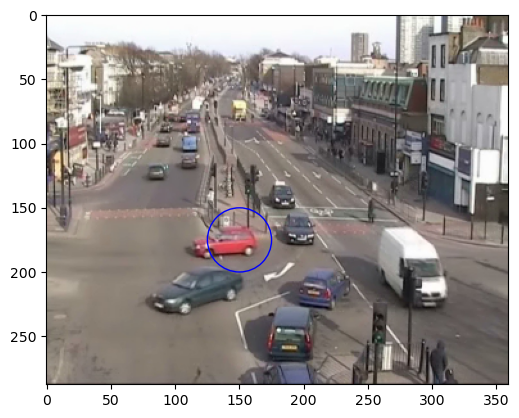

In [19]:
# plot the source image

fig, ax = plt.subplots(1)
ax.imshow(img1)
circ = plt.Circle((150, 175), radius=25, color='b', fill=False)
ax.add_patch(circ)
plt.show()     

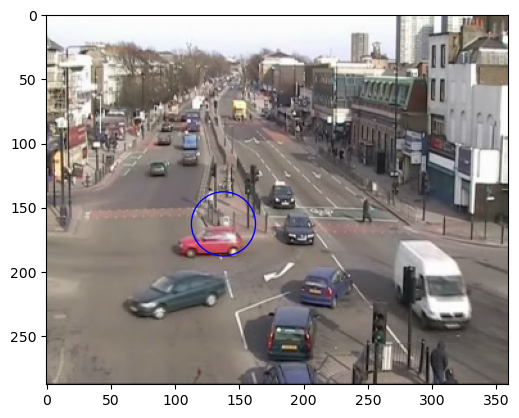

In [20]:
# plot the cirlce after 25 iterations

fig, ax = plt.subplots(1)
ax.imshow(img2)
circ = plt.Circle((x2[24], y2[24]), radius=25, color='b', fill=False)
ax.add_patch(circ)
plt.show() 

- It has done a good job following the car after 25 iterations. 
- The center seems to be little shifted probably due to drift. 
